### Import section

In [14]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

### Loss functions

In [22]:
def categorical_cross_entropy(actual, predicted):
    from math import log
    sum_score = 0.0
    for i in range(len(actual)):
        for j in range(actual[i].size):
            sum_score += actual[i][j] * log(1e-15 + predicted[i][j])
    mean_sum_score = 1.0 / len(actual) * sum_score
    return -mean_sum_score

def rmse(predictions, targets):
    differences = predictions - targets
    differences_squared = differences ** 2
    mean_of_differences_squared = differences_squared.mean()
    rmse_val = np.sqrt(mean_of_differences_squared)
    return rmse_val

### Model

In [26]:
def create_model(input_shape: int, num_of_classes=7, dense_neurons=64):
    input = keras.layers.Input(shape=(input_shape))
    layer1 = keras.layers.Dense(dense_neurons, activation=keras.activations.relu, name='dense1')(input)
    layer2 = keras.layers.Dense(dense_neurons, activation=keras.activations.relu, name='dense2')(layer1)
    layer3 = keras.layers.Dense(num_of_classes, activation=keras.activations.softmax, name='dense3')(layer2)

    model = keras.models.Model(inputs=input, outputs=layer3)

    opt = keras.optimizers.Adam(0.001)
    opt2 = keras.optimizers.RMSprop()
    # keras.metrics.Accuracy
    # keras.metrics.TopKCategoricalAccuracy()
    # keras.metrics.categorical_crossentropy
    # keras.metrics
    # model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
    model.compile(optimizer=opt, loss=rmse, metrics=['accuracy'])
    model.summary()
    return model

### Heler functions

In [10]:
def convert_categorical_values_to_numerical(df: pd.DataFrame, columns: []):
    for col in columns:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes
    return df


def split_train_validation_set(df: pd.DataFrame, validation_percent=0.1):
    size = df.shape[0]
    mask = np.random.rand(size) > validation_percent
    train = df[mask]
    test = df[~mask]
    return train, test

def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print("Accuracy: ", acc)
    print("F1 score: ", f1)
    print("Confusion matrix: \n", conf_matrix)

### Loading and splitting data

In [5]:
FILE_NAME = './nursery.data'
data = pd.read_csv(FILE_NAME)
cols = data.columns
data = convert_categorical_values_to_numerical(data, cols)
train, test = split_train_validation_set(data)

### PCA

In [17]:
pca = PCA(random_state=1)
pca.fit(data.values[:, 0:8])


PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
    svd_solver='auto', tol=0.0, whiten=False)

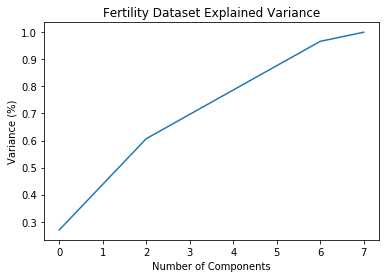

In [18]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Fertility Dataset Explained Variance')
plt.show()

### Creating model and data normalization

In [27]:
model = create_model(input_shape=data.shape[1] - 1)

X = train.values[:, 0:8]
Y = train.values[:, 8]
scaler = StandardScaler()
X = scaler.fit_transform(X)


AttributeError: 'Tensor' object has no attribute 'mean'

### Correlation

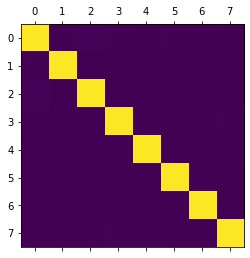

0         1         2         3         4         5         6  \
0  1.000000  0.002154  0.005211  0.002879  0.000387  0.001588  0.001414   
1  0.002154  1.000000  0.000154 -0.000868 -0.001712 -0.002426  0.003423   
2  0.005211  0.000154  1.000000  0.000878  0.003430 -0.002870  0.000884   
3  0.002879 -0.000868  0.000878  1.000000  0.004193 -0.000271  0.000710   
4  0.000387 -0.001712  0.003430  0.004193  1.000000 -0.002212  0.002842   
5  0.001588 -0.002426 -0.002870 -0.000271 -0.002212  1.000000  0.001590   
6  0.001414  0.003423  0.000884  0.000710  0.002842  0.001590  1.000000   
7 -0.002450 -0.001413  0.000096  0.004051  0.002191 -0.002318 -0.000386   

          7  
0 -0.002450  
1 -0.001413  
2  0.000096  
3  0.004051  
4  0.002191  
5 -0.002318  
6 -0.000386  
7  1.000000  


In [19]:
correlation_matrix = pd.DataFrame(X).corr()

plt.matshow(correlation_matrix)
plt.show()
print(correlation_matrix)

### Training model

In [7]:
model.fit(x=X, y=Y, epochs=1, verbose=2, validation_split=0.1)
model.save('model.h5')

Train on 10464 samples, validate on 1163 samples
10464/10464 - 4s - loss: 0.6407 - acc: 0.7549 - val_loss: 0.3238 - val_acc: 0.8340


### Validation

In [8]:
X_test = test.values[:, 0:8]
X_test = scaler.transform(X_test)
Y_test = test.values[:, 8]
predictions = model.predict(X_test)
Y_pred = predictions.argmax(axis=1)

In [11]:
evaluate_model(Y_test, Y_pred)

Accuracy:  0.8430930930930931
F1 score:  0.642063446009303
Confusion matrix: 
 [[438   0   0   0]
 [  0 370  62   0]
 [  0 107 315   0]
 [  0  40   0   0]]


In [ ]:
evaluate_model(Y_test, Y_pred)